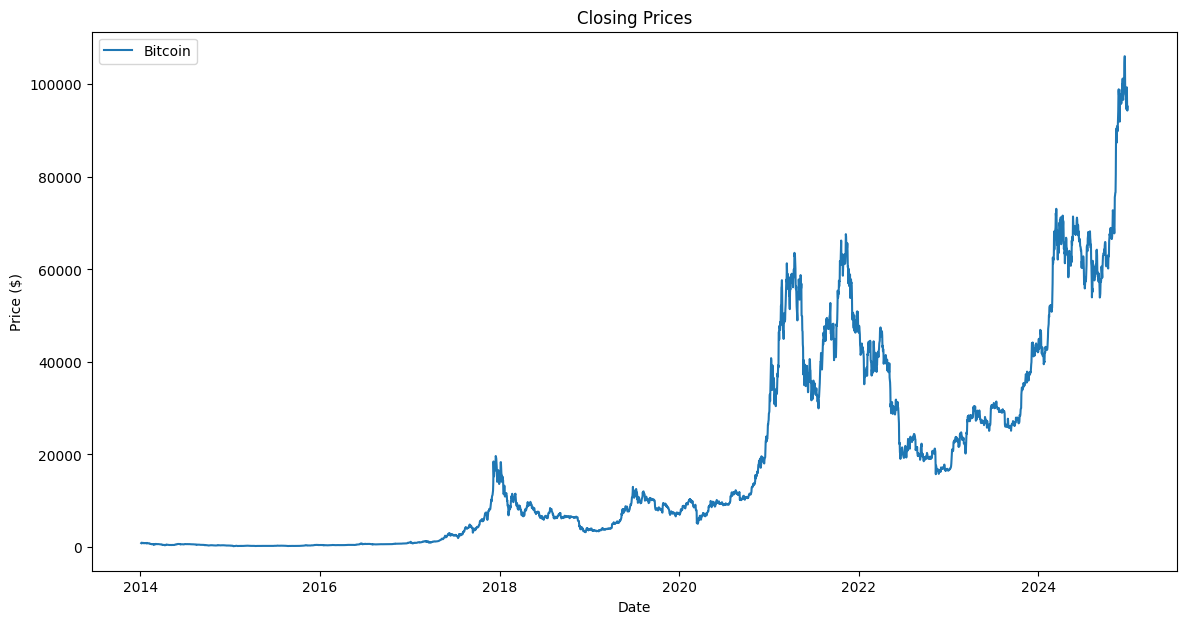

In [2]:
#load data
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

btc_data = pd.read_csv('C:/Users/Josep/OneDrive/Desktop/3/btc-usd-max.csv', parse_dates=['date'], index_col='date')
# Removing our missing data
btc_data = btc_data.iloc[250:]

# Let's see the chart!
plt.figure(figsize=(14, 7))
plt.plot(btc_data['price'], label='Bitcoin')
plt.title('Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [ ]:
# Function to create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-2*seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length:i+2*seq_length] - data[i+seq_length-1:i+2*seq_length-1]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

# Normalizing and sequence creation
sequence_length = 30  # Changed to 30

# Normalize the price data
scaler_price = MinMaxScaler()
btc_price = scaler_price.fit_transform(np.array(btc_data['price']).reshape(-1, 1))

# Normalize the volume data
scaler_volume = MinMaxScaler()
btc_volume = scaler_volume.fit_transform(np.array(btc_data['total_volume']).reshape(-1, 1))

# Combine the normalized price and volume data
btc_data_normalized = np.hstack((btc_price, btc_volume))

# Create sequences
btc_sequences, btc_targets = create_sequences(btc_data_normalized, sequence_length)

# Split the sequences into input (X) and output (y) data
X = btc_sequences
y = btc_targets

# Then do the train/test split on X and y separately
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Split the sequences into training, validation, and test data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # Ensure the output is the same shape as the input.
        output = inputs[:, :, :] + delta
        return output


# Define the LSTM model to be wrapped
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, return_sequences=True),  # This LSTM also needs to return sequences.
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(2, kernel_initializer=tf.initializers.zeros())),  # Using TimeDistributed to apply the Dense layer to each time step.
])

# Now wrap it
residual_lstm = ResidualWrapper(lstm_model)

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
residual_lstm.compile(optimizer=optimizer, loss='mse')

# Train
history = residual_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=128,
    epochs=60,
    verbose=1,
)

# Predict
y_pred = residual_lstm.predict(X_test)

Epoch 1/60
20/20 [==============================] - 9s 251ms/step - loss: 0.0160 - val_loss: 0.0074
Epoch 2/60
20/20 [==============================] - 5s 232ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 3/60
20/20 [==============================] - 5s 232ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 4/60
20/20 [==============================] - 5s 238ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 5/60
20/20 [==============================] - 5s 244ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 6/60
20/20 [==============================] - 5s 247ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 7/60
20/20 [==============================] - 5s 251ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 8/60
20/20 [==============================] - 5s 257ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 9/60
20/20 [==============================] - 5s 251ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/60
20/20 [==============================] - 5s 257ms/step - loss: 0.0020 - val_loss: 0.0018

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()